In [1]:
import pandas as pd
import datetime as dt
import pytz # timezone conversion, needed for GMT <> BST function
import matplotlib.pyplot as plt # for customising graphs

#replace this with the folder where the files are located on your PC
input_data_path = 'C:/Users/djb21211/OneDrive - University of Strathclyde/Documents/offhynetz/Scenarios/'

In [2]:
def sp_to_dt(SD, SP, period_start=True):
    """
    Converts a settlement date and settlement period to a timezone-aware
    datetime object
    Parameters
    ----------
    SD : datetime.date object
        the settlement date
    SP : int
        the settlement period (in range 1 to 50)
    period_start : bool
        whether the desired datetime object should relate to the start (True)
        or end (False) of the settlement period
    Returns
    -------
    datetime : datetime.datetime
        a timezone-aware datetime object
    """
    #check date object passed - not datetime
    if not isinstance(SD, dt.date):
        raise ValueError('Expected Settlement Date parameter not of type datetime.date')

    #minimum SP value check
    if SP < 1:
        raise ValueError('SP value of %d less than minimum value of 1' % SP)

    #maximum SP value check, taking into account transition days
    transition_days = [dt.date(x.year, x.month, x.day)
                       for x in pytz.timezone('Europe/London')._utc_transition_times]
    if SD in [x for x in transition_days if x.month<6]: #clocks go forward
        if SP > 46:
            raise ValueError('SP value of %d exceeds maximum value of 46 \
                             for forward clock change date %s' % (SP, SD))
    elif SD in [x for x in transition_days if x.month>6]: #clocks go back
        if SP > 50:
            raise ValueError('SP value of %d exceeds maximum value of 50 \
                             for backward clock change date' % SP)
    elif SP > 48:
        raise ValueError('SP value of %d exceeds maximum value of 48 for \
                         non-clock change date' % SP)

    datetime = dt.datetime(SD.year, SD.month, SD.day, tzinfo=pytz.utc)
    datetime += dt.timedelta(minutes=(SP-1)*30)
    if not period_start:
        datetime += dt.timedelta(minutes=30)

    # DST shift should only be applied on days after transition day
    # (as does not impact calculation until SP resets to 1)
    if SD in [x for x in transition_days if x.month<6]:
        pass
    elif SD in [x for x in transition_days if x.month>6] and SP > 2:
        datetime -= dt.timedelta(hours=1)
    else:
        datetime -= datetime.astimezone(pytz.timezone('Europe/London')).dst()
    return datetime

In [3]:
# example of how to use the above function: looks at year,month,date, time period on that date and converts it into time, eg 6.30am
sp_to_dt(dt.date(2021,1,1), 14)

datetime.datetime(2021, 1, 1, 6, 30, tzinfo=<UTC>)

In [4]:
# read in import data from csv file to a dataframe
# create new timestamp column using above function applied to values in SD (Settlement Date) and SP (Settlement Period) columns
# set this new timestamp column as the index
# remove the now unwanted sd/sp columns
import_df = pd.read_csv(input_data_path+'Historical data/2021/gsp_import.csv', parse_dates=[0])
import_df['timestamp'] = import_df.apply(lambda row: sp_to_dt(row.sd, row.sp), axis=1)
import_df.set_index('timestamp', inplace=True)
import_df.drop(columns=['sd', 'sp'], inplace=True)
import_df

C:\Users\djb21211\AppData\Local\Temp\ipykernel_20644\3356743482.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if SD in [x for x in transition_days if x.month<6]: #clocks go forward
C:\Users\djb21211\AppData\Local\Temp\ipykernel_20644\3356743482.py:34: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif SD in [x for x in transition_days if x.month>6]: #clocks go back
C:\Users\djb21211\AppData\Local\Temp\ipykernel_20644\3356743482.py:49: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will

,A_BRAI_1,A_BRFO_1,A_BRIM_1,A_BURM_1,A_EASO_1,A_ELST_1,A_MILH_1,A_NORM_1,A_PELH_1,A_RAYL_1,...,P_TUMB_P,P_WIOW_P,P_ARDK_P,P_QUOI_P,P_ORRI_P,P_BERB_P,P_FETT_P,P_CAIF_P,P_HARG_P,P_STOR_P
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,64.850,146.494,106.330,87.196,59.245,112.969,64.630,NaN,57.835,119.390,...,NaN,6.596,NaN,NaN,NaN,NaN,NaN,NaN,0.784,NaN
2021-01-01 00:30:00+00:00,65.635,169.179,106.050,91.591,62.530,114.465,62.655,NaN,58.920,124.400,...,NaN,6.413,NaN,NaN,NaN,NaN,NaN,NaN,0.745,NaN
2021-01-01 01:00:00+00:00,64.805,169.799,104.240,89.862,61.605,109.465,61.110,NaN,56.605,121.520,...,NaN,6.375,NaN,NaN,NaN,NaN,NaN,NaN,0.704,NaN
2021-01-01 01:30:00+00:00,63.215,162.684,98.625,88.002,59.550,103.291,57.560,NaN,56.620,117.255,...,NaN,6.166,NaN,NaN,NaN,NaN,NaN,NaN,0.765,NaN
2021-01-01 02:00:00+00:00,61.650,156.839,93.220,85.749,57.315,97.774,55.160,NaN,55.285,112.510,...,NaN,5.971,NaN,NaN,NaN,NaN,NaN,NaN,0.814,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,59.080,59.374,101.856,67.680,45.610,105.184,52.765,31.557,52.685,94.350,...,NaN,6.009,NaN,NaN,0.052,NaN,NaN,NaN,NaN,3.539
2021-12-31 22:00:00+00:00,58.630,42.309,98.552,65.090,43.035,98.075,52.980,59.642,52.525,86.010,...,NaN,5.796,NaN,NaN,0.058,NaN,NaN,NaN,NaN,1.974
2021-12-31 22:30:00+00:00,57.710,56.459,96.207,63.610,38.015,92.702,52.295,81.079,52.180,82.695,...,NaN,5.868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.381


In [5]:
# repeat the above steps for the export data
export_df = pd.read_csv(input_data_path+'Historical data/2021/gsp_export.csv', parse_dates=[0])
export_df['timestamp'] = export_df.apply(lambda row: sp_to_dt(row.sd, row.sp), axis=1)
export_df.set_index('timestamp', inplace=True)
export_df.drop(columns=['sd', 'sp'], inplace=True)
export_df

C:\Users\djb21211\AppData\Local\Temp\ipykernel_20644\3356743482.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if SD in [x for x in transition_days if x.month<6]: #clocks go forward
C:\Users\djb21211\AppData\Local\Temp\ipykernel_20644\3356743482.py:34: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif SD in [x for x in transition_days if x.month>6]: #clocks go back
C:\Users\djb21211\AppData\Local\Temp\ipykernel_20644\3356743482.py:49: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will

,A_BRAI_1,A_BRFO_1,A_BRIM_1,A_BURM_1,A_EASO_1,A_ELST_1,A_MILH_1,A_NORM_1,A_PELH_1,A_RAYL_1,...,P_TUMB_P,P_WIOW_P,P_ARDK_P,P_QUOI_P,P_ORRI_P,P_BERB_P,P_FETT_P,P_CAIF_P,P_HARG_P,P_STOR_P
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.330,NaN,NaN,...,7.182,NaN,0.876,8.28,1.630,7.31,32.930,8.041,NaN,0.861
2021-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.180,NaN,NaN,...,7.024,NaN,1.469,8.27,1.182,7.79,34.190,10.025,NaN,0.830
2021-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.130,NaN,NaN,...,6.522,NaN,1.717,8.26,1.439,6.09,34.040,7.841,NaN,0.792
2021-01-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.986,NaN,NaN,...,6.470,NaN,2.793,8.26,1.154,4.18,32.320,9.924,NaN,0.859
2021-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.372,NaN,NaN,...,6.584,NaN,3.354,8.25,2.015,3.67,30.420,11.020,NaN,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.414,NaN,0.217,1.12,NaN,10.09,2.760,0.630,3.672,NaN
2021-12-31 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.608,NaN,0.540,1.10,NaN,5.89,0.734,0.394,2.096,NaN
2021-12-31 22:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.828,NaN,1.860,1.07,0.078,3.70,0.564,0.322,2.497,NaN


<AxesSubplot:xlabel='timestamp'>

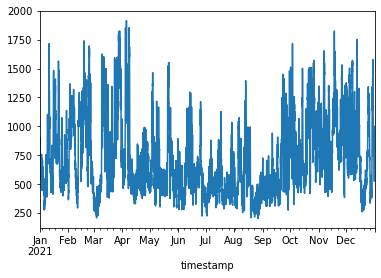

In [6]:
# create a timeseries plot of the export values summed across each row
export_df.sum(axis=1).plot()

In [7]:
# make a new dataframe which is the sum of import and export values
# need to multiply exports by -1 because they are recorded as negative energy
unconstrained_df = import_df.fillna(0)+(-1*export_df.fillna(0))
unconstrained_df

,A_BRAI_1,A_BRFO_1,A_BRIM_1,A_BURM_1,A_EASO_1,A_ELST_1,A_MILH_1,A_NORM_1,A_PELH_1,A_RAYL_1,...,P_TUMB_P,P_WIOW_P,P_ARDK_P,P_QUOI_P,P_ORRI_P,P_BERB_P,P_FETT_P,P_CAIF_P,P_HARG_P,P_STOR_P
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,64.850,146.494,106.330,87.196,59.245,112.969,64.630,-66.330,57.835,119.390,...,-7.182,6.596,-0.876,-8.28,-1.630,-7.31,-32.930,-8.041,0.784,-0.861
2021-01-01 00:30:00+00:00,65.635,169.179,106.050,91.591,62.530,114.465,62.655,-66.180,58.920,124.400,...,-7.024,6.413,-1.469,-8.27,-1.182,-7.79,-34.190,-10.025,0.745,-0.830
2021-01-01 01:00:00+00:00,64.805,169.799,104.240,89.862,61.605,109.465,61.110,-67.130,56.605,121.520,...,-6.522,6.375,-1.717,-8.26,-1.439,-6.09,-34.040,-7.841,0.704,-0.792
2021-01-01 01:30:00+00:00,63.215,162.684,98.625,88.002,59.550,103.291,57.560,-71.986,56.620,117.255,...,-6.470,6.166,-2.793,-8.26,-1.154,-4.18,-32.320,-9.924,0.765,-0.859
2021-01-01 02:00:00+00:00,61.650,156.839,93.220,85.749,57.315,97.774,55.160,-77.372,55.285,112.510,...,-6.584,5.971,-3.354,-8.25,-2.015,-3.67,-30.420,-11.020,0.814,-0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,59.080,59.374,101.856,67.680,45.610,105.184,52.765,31.557,52.685,94.350,...,-8.414,6.009,-0.217,-1.12,0.052,-10.09,-2.760,-0.630,-3.672,3.539
2021-12-31 22:00:00+00:00,58.630,42.309,98.552,65.090,43.035,98.075,52.980,59.642,52.525,86.010,...,-8.608,5.796,-0.540,-1.10,0.058,-5.89,-0.734,-0.394,-2.096,1.974
2021-12-31 22:30:00+00:00,57.710,56.459,96.207,63.610,38.015,92.702,52.295,81.079,52.180,82.695,...,-8.828,5.868,-1.860,-1.07,-0.078,-3.70,-0.564,-0.322,-2.497,2.381


In [8]:
scottish_gsps = [x for x in import_df.columns.values if x.startswith('N') or x.startswith('P')]

In [9]:
# we can then filter the timeseries data by these values
# to return a dataframe which only has wind BMUs
wind_ts_df = import_df.filter(scottish_gsps)
wind_ts_df

,N_TONG1,N_AYRR,N_BAIN,N_BROX,N_CAFA,N_CATY,N_CHAS,N_COAT,N_COCK,N_CURR,...,P_TUMB_P,P_WIOW_P,P_ARDK_P,P_QUOI_P,P_ORRI_P,P_BERB_P,P_FETT_P,P_CAIF_P,P_HARG_P,P_STOR_P
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,NaN,11.77,4.923,11.97,NaN,3.300,17.333,15.765,12.91,2.897,...,NaN,6.596,NaN,NaN,NaN,NaN,NaN,NaN,0.784,NaN
2021-01-01 00:30:00+00:00,NaN,11.60,4.872,11.64,NaN,3.220,17.319,15.449,12.52,2.810,...,NaN,6.413,NaN,NaN,NaN,NaN,NaN,NaN,0.745,NaN
2021-01-01 01:00:00+00:00,NaN,11.16,5.064,10.25,NaN,3.085,17.198,14.981,12.63,2.691,...,NaN,6.375,NaN,NaN,NaN,NaN,NaN,NaN,0.704,NaN
2021-01-01 01:30:00+00:00,NaN,10.64,4.792,10.99,NaN,2.900,16.462,14.432,12.29,2.579,...,NaN,6.166,NaN,NaN,NaN,NaN,NaN,NaN,0.765,NaN
2021-01-01 02:00:00+00:00,NaN,10.19,4.636,10.60,NaN,2.725,15.899,13.860,11.85,2.494,...,NaN,5.971,NaN,NaN,NaN,NaN,NaN,NaN,0.814,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,NaN,12.37,7.737,11.69,NaN,3.935,14.801,16.034,13.47,3.006,...,NaN,6.009,NaN,NaN,0.052,NaN,NaN,NaN,NaN,3.539
2021-12-31 22:00:00+00:00,NaN,11.88,7.403,12.15,NaN,3.830,14.319,15.545,12.75,2.897,...,NaN,5.796,NaN,NaN,0.058,NaN,NaN,NaN,NaN,1.974
2021-12-31 22:30:00+00:00,NaN,11.51,7.265,11.17,NaN,3.690,14.083,15.033,12.32,2.793,...,NaN,5.868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.381


<AxesSubplot:xlabel='timestamp'>

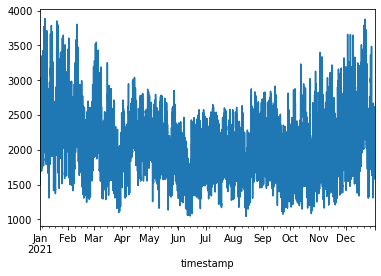

In [10]:
# plot the total wind output by time
(wind_ts_df*2).sum(axis=1).plot()

<AxesSubplot:xlabel='timestamp'>

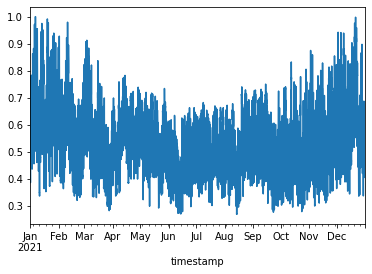

In [11]:
demand_ts = ((wind_ts_df*2).sum(axis=1)/(wind_ts_df*2).sum(axis=1).max())
demand_ts.plot()

<AxesSubplot:>

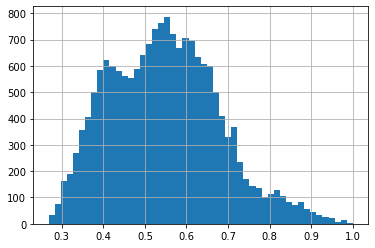

In [12]:
# plot histogram to show distribution of wind CFs
demand_ts.hist(bins=50)

In [13]:
(demand_ts*-1).to_csv('scottish_demand.csv', header=['region1'], index_label='', date_format='%Y-%m-%d %H:%M')